In [1]:
# 라이브러리 불러오기
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

# 코랩 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/data/project03

/content/drive/MyDrive/data/project03


# 캐글 데이터 다운

In [4]:
# 캐글에서 json 파일 받기
!pip install kaggle
from google.colab import files
files.upload()
# json 파일 업로드

{}

In [5]:
# json 파일 업로드 확인
!ls -1ha kaggle.json

kaggle.json


In [6]:
# json 파일 사용을 위한 작업
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         62           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         81           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        471           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        151           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1456           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14810           False  
house-pr

# 케글 데이터 api 다운로드

In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.15G/8.16G [01:02<00:00, 142MB/s]
100% 8.16G/8.16G [01:02<00:00, 140MB/s]


## 다운받은 zip 파일 압축 해제

In [7]:
import os
import zipfile

In [ ]:
with zipfile.ZipFile(f'flickr-image-dataset.zip', 'r') as existing_zip: # 압축파일 경로 설정
        foldername = 'flickr-image-dataset' # 폴더 이름 추출
        existing_zip.extractall() #압축을 풀어 폴더에 넣기

In [8]:
!pip install --upgrade -q wandb

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 139 kB 76.7 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 180 kB 69.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [9]:
import wandb

import tensorflow as tf
from tensorflow.keras.layers import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import IPython

In [10]:
data_dir = 'flickr30k_images'
image_dir = f'{data_dir}/flickr30k_images'
csv_file = f'{data_dir}/results.csv'

In [11]:
df = pd.read_csv(csv_file, delimiter='|')

print(f'[INFO] The shape of dataframe: {df.shape}')
print(f'[INFO] The columns in the dataframe: {df.columns}')
print(f'[INFO] Unique image names: {len(pd.unique(df["image_name"]))}')

[INFO] The shape of dataframe: (158915, 3)
[INFO] The columns in the dataframe: Index(['image_name', ' comment_number', ' comment'], dtype='object')
[INFO] Unique image names: 31783


In [12]:
df.columns = ['image_name', 'comment_number', 'comment']
del df['comment_number']

# Under scrutiny I had found that 19999 had a messed up entry
df['comment'][19999] = ' A dog runs across the grass .'

# Image names now correspond to the absolute position
df['image_name'] = image_dir+'/'+df['image_name']

# <start> comment <end>
df['comment'] = "<start> "+df['comment']+" <end>"

In [13]:
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image_name,comment
0,flickr30k_images/flickr30k_images/3822535114.jpg,<start> Two women eating while smiling for th...
1,flickr30k_images/flickr30k_images/5169120032.jpg,<start> A group of adults eats something whil...
2,flickr30k_images/flickr30k_images/4688203626.jpg,<start> A busy city street with large buildin...
3,flickr30k_images/flickr30k_images/3439243433.jpg,<start> A white dog standing on leaves on the...
4,flickr30k_images/flickr30k_images/3041689520.jpg,<start> Naked children play on the muddy rive...


In [14]:
SIZE = len(df)

train_size = int(0.7* SIZE) 
val_size = int(0.1* SIZE)
test_size = int(0.2* SIZE)

train_size, val_size, test_size

(111240, 15891, 31783)

In [15]:
train_df = df.iloc[:train_size,:]
val_df = df.iloc[train_size+1:train_size+val_size,:]
test_df = df.iloc[train_size+val_size+1:,:]

<start>  It is a march of people of different backgrounds all walking and one guy in a green shirt holds a flag . <end>


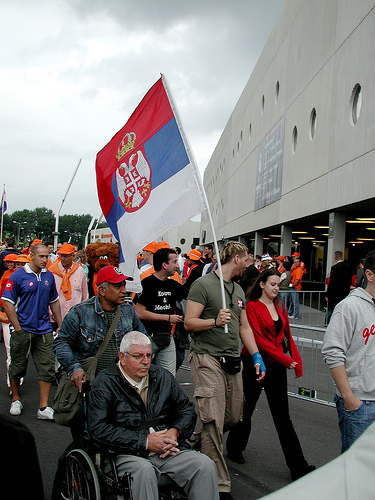

In [17]:
# Enter different indices.
index = 200

image_name = train_df['image_name'][index]
comment = train_df['comment'][index]

print(comment)

IPython.display.Image(filename=image_name)

In [18]:
# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

In [19]:
# build the vocabulary
tokenizer.fit_on_texts(train_df['comment'])

In [20]:
# This is a sanity check function
def check_vocab(word):
    i = tokenizer.word_index[word]
    print(f"The index of the word: {i}")
    print(f"Index {i} is word {tokenizer.index_word[i]}")
    
check_vocab("pajama")

The index of the word: 4375
Index 4375 is word pajama


In [21]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [22]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_df['comment'])
val_seqs = tokenizer.texts_to_sequences(val_df['comment'])
test_seqs = tokenizer.texts_to_sequences(test_df['comment'])

In [23]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')
test_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

In [24]:
# Caption vector
train_cap_vector.shape, val_cap_vector.shape, test_cap_vector.shape

((111240, 80), (15890, 75), (31783, 74))

In [25]:
train_cap_ds = tf.data.Dataset.from_tensor_slices(train_cap_vector)
val_cap_ds = tf.data.Dataset.from_tensor_slices(val_cap_vector)
test_cap_ds = tf.data.Dataset.from_tensor_slices(test_cap_vector)

In [26]:
@tf.function
def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    return img

In [27]:
train_img_name = train_df['image_name'].values
val_img_name = val_df['image_name'].values
test_img_name = test_df['image_name'].values

In [28]:
train_img_ds = tf.data.Dataset.from_tensor_slices(train_img_name).map(load_img)
val_img_ds = tf.data.Dataset.from_tensor_slices(val_img_name).map(load_img)
test_img_ds = tf.data.Dataset.from_tensor_slices(test_img_name).map(load_img)

In [29]:
# prefecth and batch the dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512

train_ds = tf.data.Dataset.zip((train_img_ds, train_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_img_ds, val_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.zip((test_img_ds, test_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [30]:
run = wandb.init(project="show-and-tell",
                 entity="collaborativeml",
                 name="ariG-devJ-img-cap",
                 save_code=False)

images = []
for img, cap in test_ds.take(1):
    batch_size = img.shape[0]
    for i in range(batch_size):
        text = []
        for c in cap[i]:
            if c.numpy() == 0:
                break
            text.append(tokenizer.index_word[c.numpy()])
        images.append(wandb.Image(img[i],
                                  caption=' '.join(text)))
run.log({"img":images})
run.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Problem at: <ipython-input-30-ded48def3e7f> 4 <module>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 870, in init
    run = wi.init()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 566, in init
    backend.cleanup()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/backend/backend.py", line 228, in cleanup
    self.interface.join()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py", line 481, in join
    super(InterfaceQueue, self).join()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 591, in join
    self._communicate_shutdown()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py", line 478, in _communicate_shutdown
    _ = self._communicate(record)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py", line 232, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=ti

Exception: ignored

In [ ]:
# Some global variables
EMBEDDIN_DIM = 512
VOCAB_SIZE = 10000
UNITS_RNN = 256

In [ ]:
class CNN_Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        
    def build(self, input_shape):
        self.resnet = tf.keras.applications.ResNet50(include_top=False,
                                                     weights='imagenet')
        self.resnet.trainable=False
        self.gap = GlobalAveragePooling2D()
        self.fc = Dense(units=self.embedding_dim,
                        activation='sigmoid')
        
    def call(self, x):
        x = self.resnet(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

In [ ]:
# Checking the CNN
encoder = CNN_Encoder(EMBEDDIN_DIM)
for image, caption in train_ds.take(1):
    print(encoder(image).shape)
    break

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.embedding = Embedding(input_dim=self.vocab_size,
                                   output_dim=self.embedding_dim)
    
    def build(self, input_shape):
        self.gru1 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru2 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru3 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru4 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(self.vocab_size)

    def call(self, x, initial_zero=False):
        # x, (batch, 512)
        # hidden, (batch, 256)
        if initial_zero:
            initial_state = decoder.reset_state(batch_size=x.shape[0])
            output, state = self.gru1(inputs=x,
                                      initial_state=initial_state)
            output, state = self.gru2(inputs=output,
                                      initial_state=initial_state)
            output, state = self.gru3(inputs=output,
                                      initial_state=initial_state)
            output, state = self.gru4(inputs=output,
                                      initial_state=initial_state)
        else:
            output, state = self.gru1(inputs=x)
            output, state = self.gru2(inputs=output)
            output, state = self.gru3(inputs=output)
            output, state = self.gru4(inputs=output)
        # output, (batch, 256)
        x = self.fc1(output)
        x = self.fc2(x)
        
        return x, state
    
    def embed(self, x):
        return self.embedding(x)
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
# Checking the RNN
decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)
for image, caption in train_ds.take(1):
    features = tf.expand_dims(encoder(image),1) # (batch, 1, 128)
    em_words = decoder.embed(caption)
    x = tf.concat([features,em_words],axis=1)
    print(x.shape)
    predictions, state = decoder(x, True)
    print(predictions.shape)
    print(state.shape)

In [ ]:
encoder = CNN_Encoder(EMBEDDIN_DIM)
decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:
@tf.function
def train_step(img_tensor, target):
    # img_tensor (batch, 224,224,3)
    # target     (batch, 80)
    loss = 0
    with tf.GradientTape() as tape:
        features = tf.expand_dims(encoder(img_tensor),1) # (batch, 1, 128)
        em_words = decoder.embed(target)
        x = tf.concat([features,em_words],axis=1)
        predictions, _ = decoder(x, True)

        loss = loss_function(target[:,1:], predictions[:,1:-1,:])

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [ ]:
@tf.function
def val_step(img_tensor, target):
    # img_tensor (batch, 224,224,3)
    # target     (batch, 80)
    loss = 0
    features = tf.expand_dims(encoder(img_tensor),1) # (batch, 1, 128)
    em_words = decoder.embed(target)
    x = tf.concat([features,em_words],axis=1)
    predictions, _ = decoder(x, True)
    loss = loss_function(target[:,1:], predictions[:,1:-1,:])
    return loss

In [ ]:
from tqdm import tqdm

In [ ]:

EPOCHS = 15
epoch_wise_loss = []
epoch_wise_val_loss = []
for epoch in range(EPOCHS):
    batch_wise_loss = []
    for (batch, (img_tensor, target)) in enumerate(train_ds):
        loss = train_step(img_tensor, target)
        batch_wise_loss.append(loss.numpy())
        if batch%100 == 0:
            print(f'Epoch: {epoch} Batch: {batch} Loss: {batch_wise_loss[-1]:.3f}')
    epoch_wise_loss.append(np.mean(batch_wise_loss))
    
    batch_wise_val_loss = []
    for (batch, (img_tensor, target)) in enumerate(val_ds):
        loss = val_step(img_tensor, target)
        batch_wise_val_loss.append(loss.numpy())
    epoch_wise_val_loss.append(np.mean(batch_wise_val_loss))
    print(f'Epoch: {epoch} Total Loss: {epoch_wise_loss[-1]:.3f} Val Loss:{epoch_wise_val_loss[-1]:.3f}')
    print('-'*40)

In [ ]:
run = wandb.init(project="show-and-tell",
                 entity="collaborativeml",
                 name="ariG-devJ-model_train",
                 save_code=False)
with run:
    for idx,loss in enumerate(epoch_wise_loss):
        run.log({"Train_Loss":loss, "Epoch_Train":idx})
    for idx,loss in enumerate(epoch_wise_val_loss):
        run.log({"Val_Loss":loss, "Epoch_Val":idx})

In [ ]:
!mkdir models
encoder.save_weights('./models/encoder.h5')
decoder.save_weights('./models/decoder.h5')

In [ ]:
encoder = CNN_Encoder(EMBEDDIN_DIM)
for image, caption in train_ds.take(1):
    encoder(image)

decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)
for image, caption in train_ds.take(1):
    features = tf.expand_dims(encoder(image),1)
    em_words = decoder.embed(caption)
    x = tf.concat([features,em_words],axis=1)
    predictions, state = decoder(x, True)

encoder.load_weights('./models/encoder.h5')
decoder.load_weights('./models/decoder.h5')

In [ ]:
batch_loss = []
for (batch, (img_tensor, target)) in tqdm(enumerate(test_ds.take(10))):
    loss = val_step(img_tensor, target)
    batch_loss.append(loss.numpy())
print(f'Test Loss: {np.mean(batch_loss):.3f}')

In [ ]:
run = wandb.init(project="show-and-tell",
                 entity="collaborativeml",
                 name="ariG-devJ-models",
                 save_code=False)
with run:
    trained_model_artifact = wandb.Artifact("encoder_decoder",
                                            type="model",
                                            description="vision encoder and text decoder",)
    trained_model_artifact.add_dir('./models/')
    run.log_artifact(trained_model_artifact)

In [ ]:
img, cap = next(iter(test_ds.take(1)))

img[0].shape, cap[0].shape